# Code for loading in the datasets and modelling

In [1]:
#from loader import list_files, Files, Folders  #precalculate what we are loading in
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sys import getsizeof
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import os

path="/its/home/drs25/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"

In [3]:
import opendatasets as od
dataset = 'https://www.kaggle.com/datasets/dextershepherd/texture-tactip'
# Using opendatasets let's download the data sets
od.download(dataset)
dataset = 'https://www.kaggle.com/datasets/dextershepherd/optical-tactile-dataset-for-textures'
# Using opendatasets let's download the data sets
od.download(dataset)
dataset = 'https://www.kaggle.com/datasets/dextershepherd/electrical-tactile-sensor'
# Using opendatasets let's download the data sets
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Abort: 

## Load in data

In [3]:
class loaded:
    def __init__(self,t=20,filename="X_data_15.npz"):
        data = np.load(datapath+filename) #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load(datapath+filename.replace("X","y")) #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys=['Leather', 'Cork', 'wool', 'LacedMatt', 'Gfoam', 'Plastic', 'Carpet', 'bubble', 'Efoam', 'cotton', 'LongCarpet', 'Flat', 'felt', 'Jeans', 'Ffoam']

        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        self.X = self.AugmentedX
        self.y = self.Augmentedy
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
        del self.AugmentedX
        del self.Augmentedy
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined
#data=loaded(t=13)
#data.applySobel()
#data.augment()

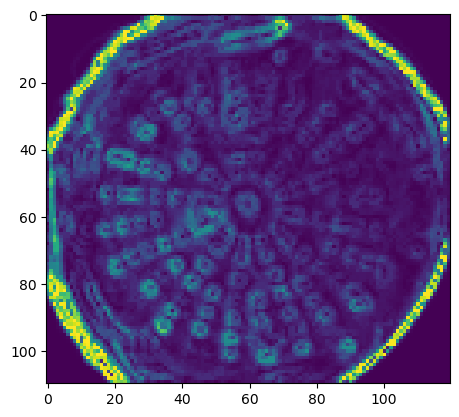

In [3]:
plt.imshow(data.X[0][0])
plt.show()
#plt.savefig("test.png")

In [ ]:
data.applySobel()

IndexError: index 10 is out of bounds for axis 0 with size 10

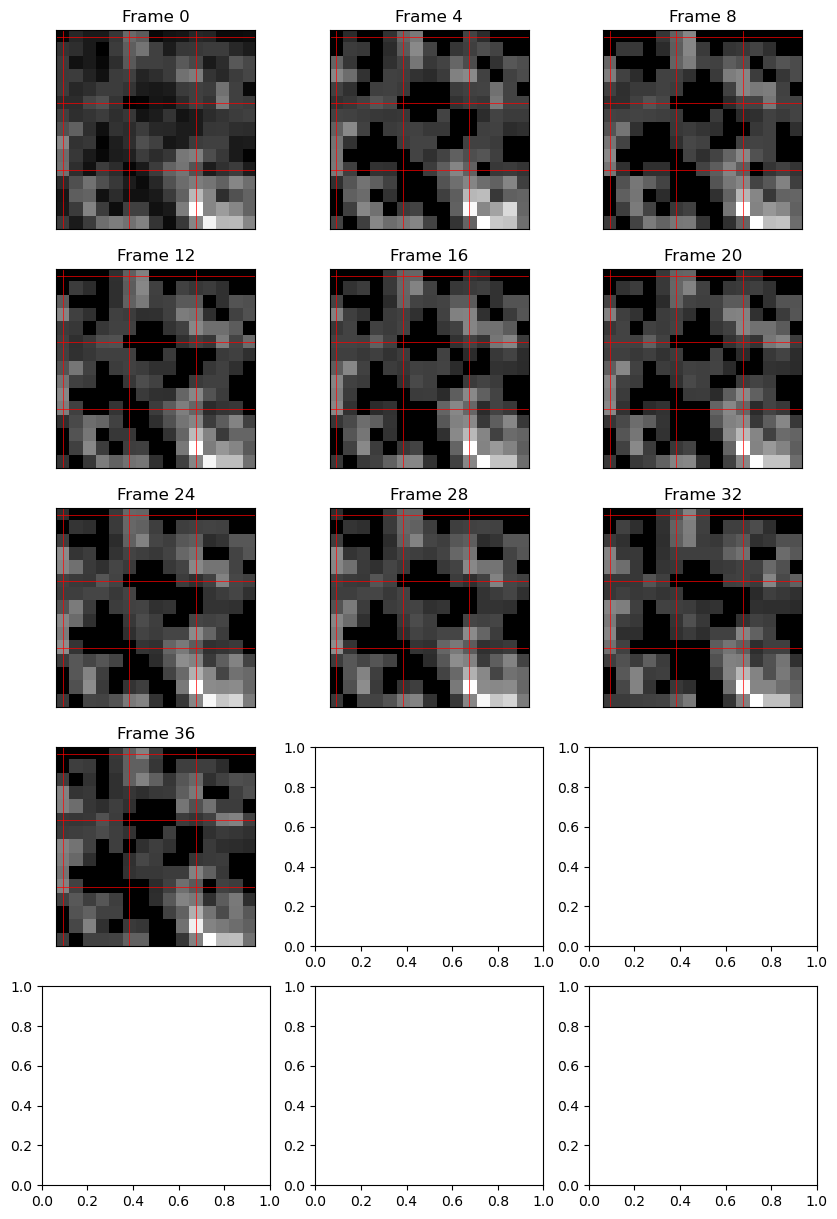

In [6]:
num_images = 15
texture=np.random.randint(0,100)
images = data.X[texture][0:15]

num_rows = 5
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15))

# Flatten the axes array for easy indexing
axes = axes.flatten()
ax = axes[0]
ax.set_title("Frame "+str(0))
ax.imshow(images[0][50:65,50:65], cmap='gray')
ax.set_xticks(np.arange(0, 15, 5))
# Set custom ticks for y-axis (every 10 units)
ax.set_yticks(np.arange(0, 15, 5))
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.5)
# Plot each image
imageA=images[0].astype(np.uint8)
kernel=np.array((9,9))
for i in range(1,num_images):
    imageB=images[i].astype(np.uint8)
    imageB[imageB<20]=0

    ax = axes[i]
    ax.imshow(imageB[50:65,50:65],cmap="gray")
    #ax.axis('off')
    ax.set_xticks(np.arange(0, 15, 5))
    # Set custom ticks for y-axis (every 10 units)
    ax.set_yticks(np.arange(0, 15, 5))
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.5)
    ax.set_title("Frame "+str(i*4))
    

# Remove any empty subplots
for i in range(num_images, num_rows*num_cols):
    fig.delaxes(axes[i])

#plt.suptitle("Flow of "+str(data.keys[data.y[texture]]))
plt.tight_layout()
#plt.savefig("/its/home/drs25/Pictures/TacTip real/rigData/centrepointMove.pdf")
plt.show()

## Look at spread of changes

In [ ]:
#change=[np.zeros((len(data.X[0]))) for i in range(len(data.keys))]
change=np.zeros((len(data.X),41,20))
counter=[0 for i in range(len(data.keys))]
for i in range(len(data.X)):
    y=data.y[i]
    framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
    framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
    difference=np.abs(np.sum(framesA-framesB,axis=1))
    change[y][counter[y]]=difference
    counter[y]+=1

change=(np.array(change).T/np.array(counter)).T
change.shape

IndexError: list index out of range

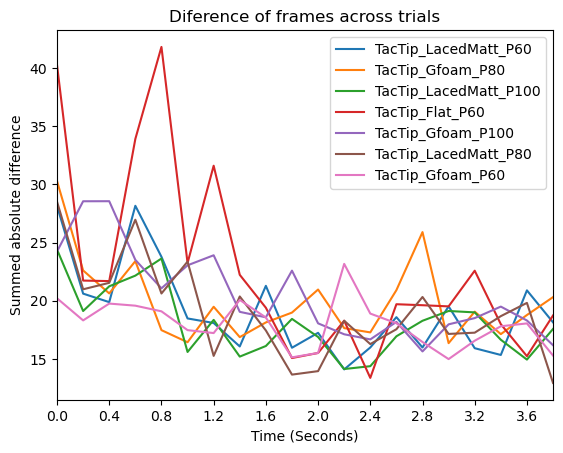

In [ ]:
av=np.average(change,axis=1)
for i in range(len(change)):
    plt.plot(av[i],label=data.keys[i])

plt.legend(loc="upper right")
plt.xticks([i for i in range(0,len(change[2]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[2]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.xlim([0,19])
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across trials")
plt.show()

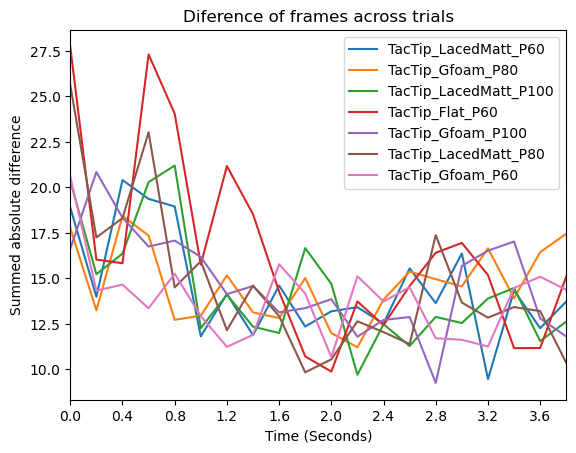

In [ ]:
av=np.std(change,axis=1)
for i in range(len(change)):
    plt.plot(av[i],label=data.keys[i])

plt.legend(loc="upper right")
plt.xticks([i for i in range(0,len(change[2]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[2]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.xlim([0,19])
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across trials")
plt.show()

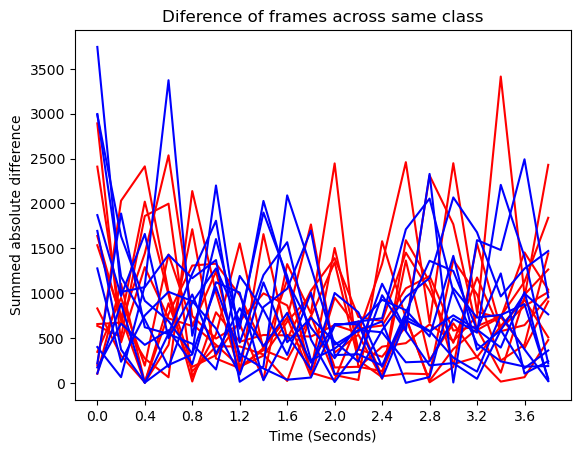

In [ ]:
found=0
i=0
while found<10:
    y=data.y[i]
    if y==0:
        framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
        framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
        difference=np.abs(np.sum(framesA-framesB,axis=1))
        plt.plot(difference,c="r")
        found+=1
    i+=1
i=0
found=0
while found<10:
    y=data.y[i]
    if y==5:
        framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
        framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
        difference=np.abs(np.sum(framesA-framesB,axis=1))
        plt.plot(difference,c="b")
        found+=1
    i+=1

plt.xticks([i for i in range(0,len(change[0]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[0]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across same class")
plt.show()
    

# Machine learning
## Regression
### Ridge

In [180]:
reformed_X=data.X[:,:4].reshape(len(data.X[:,:4]),4*110*120) 
n=int(len(data.X)/3)
train_X=reformed_X[:n]
train_y=data.y[:n]
test_X=reformed_X[n:n+2000]
test_y=data.y[n:n+2000]
print(n,test_X.shape,train_X.shape)

1600 (2000, 52800) (1600, 52800)


In [12]:
alpha = 1.0  # Regularization parameter

# Define the Ridge regression model
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(train_X, train_y)
predictions = np.round(ridge_model.predict(test_X))
a=predictions.astype(np.int8)-test_y.astype(np.int8)
correct=len(a[a==0])
print("Accuracy",correct/len(a)*100,"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy 72.55 %
average loss 0.293


In [14]:
# t exp
alpha = 1.0 
t_ridge_train=[]
t_ridge_test=[]
for i in range(1,20,1):
    d=data.X[:,:i]
    reformed_X=data.X[:,:4].reshape(len(data.X[:,:4]),4*110*120) 
    n=int(len(data.X)/3)
    train_X=reformed_X[:n]
    train_y=data.y[:n]
    test_X=reformed_X[n:n+2000]
    test_y=data.y[n:n+2000]
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(train_X, train_y)
    predictionsX = ridge_model.predict(train_X)
    predictions = ridge_model.predict(test_X)
    a=(predictionsX.astype(np.int8)-train_y.astype(np.int8))
    t_ridge_train.append(len(a[a==0])/len(a))
    a=(predictions.astype(np.int8)-test_y.astype(np.int8))
    t_ridge_test.append(len(a[a==0])/len(a))
    print("accuracy at",i,":",(len(a[a==0])/len(a))*100,"%")
    del d
    del train_X
    del test_X
    del ridge_model
t_ridge_test=np.array(t_ridge_test)
t_ridge_train=np.array(t_ridge_train)
print(t_ridge_test,t_ridge_test.dtype)
np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_ridge_train",t_ridge_train)
np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_ridge_test",t_ridge_test)

accuracy at 1 : 45.88888888888889 %
accuracy at 2 : 49.44444444444444 %
accuracy at 3 : 48.333333333333336 %
accuracy at 4 : 48.888888888888886 %
accuracy at 5 : 48.55555555555556 %
accuracy at 6 : 48.66666666666667 %
accuracy at 7 : 48.22222222222222 %
accuracy at 8 : 48.44444444444444 %


In [ ]:
print("Accuracy:",(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions),"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy: 0.6411111111111111 %
average loss 0.35888888888888887


### Linear

In [ ]:
reformed_X=data.X.reshape(4800,20*110*120)
train_X=reformed_X[:2000]
train_y=data.y[0:2000]
test_X=reformed_X[2000:2900]
test_y=data.y[2000:2900]
print(test_X.shape,train_X.shape)

(900, 264000) (2000, 264000)


In [ ]:
linear_model = LinearRegression()

# Fit the model
linear_model.fit(train_X, train_y)
predictions = linear_model.predict(test_X)
print("Accuracy:",(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions),"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy: 0.7588888888888888 %
average loss 0.2411111111111111


In [7]:
# t exp
t_lin_train=[]
t_lin_test=[]
for i in range(1,12,1):
    d=data.AugmentedX[:,:i]
    reformed_X=d.reshape(len(data.AugmentedX),(i)*110*120) 
    train_X=reformed_X[:3000]
    train_y=data.Augmentedy[0:3000]
    test_X=reformed_X[3000:3900]
    test_y=data.Augmentedy[3000:3900]
    linear_model = LinearRegression()
    linear_model.fit(train_X, train_y)
    predictionsX = linear_model.predict(train_X)
    predictions = linear_model.predict(test_X)
    a=(predictionsX.astype(np.uint8)-train_y)
    t_lin_train.append(len(a[a==0])/len(a))
    a=(predictions.astype(np.uint8)-test_y)
    t_lin_test.append(len(a[a==0])/len(a))
    del d
    del train_X
    del test_X
    del linear_model
t_lin_test=np.array(t_lin_test)
t_lin_train=np.array(t_lin_train)
np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_lin_train_augmented",t_lin_train)
np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_lin_test_augmented",t_lin_test)

### Random forest

In [41]:

data=loaded(t=15)
data.applySobel()
reformed_X=data.X.reshape(len(data.X),data.X.shape[1]*data.X.shape[2]*data.X.shape[3])
train_X, test_X, train_y, test_y = train_test_split(reformed_X, data.y, test_size=0.2, random_state=42)

print(test_X.shape,train_X.shape)

Dataset size: 750 
Window size: 4 
Image: (260, 270)
Memory needed: 0.2 GB
(150, 280800) (600, 280800)


In [42]:
# Define the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=25, random_state=42)

# Fit the model
rf_model.fit(train_X, train_y)

predictions = rf_model.predict(test_X)
a=(predictions.astype(np.uint8)-test_y)
a = (len(a[a==0]))/len(predictions)
print("Accuracy:",a*100,"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))
np.save(path+"/data/test_y_t=20",test_y)
np.save(path+"/data/predictionsRandomForest_t=20",predictions)

Accuracy: -0.9666666666666667 %
average loss 1.9666666666666666


In [3]:
# t exp
t_for_train=[]
t_for_test=[]
for i in range(1,12,1):
    print(i)
    data=loaded(t=i)
    data.applySobel()
    data.augment()
    reformed_X=data.X.reshape(len(data.X),data.X.shape[1]*data.X.shape[2]*data.X.shape[3])
    train_X, test_X, train_y, test_y = train_test_split(reformed_X, data.y, test_size=0.2, random_state=42)
    rf_model = RandomForestRegressor(n_estimators=25, random_state=42)
    # Fit the model
    rf_model.fit(train_X, train_y)
    predictionsX = np.round(rf_model.predict(train_X))
    predictions = np.round(rf_model.predict(test_X))
    a=np.round(np.abs(predictionsX-train_y))
    a=(len(a[a==0]))/len(predictionsX)
    t_for_train.append(a)
    print(a*100,"%")
    a=np.round(np.abs(predictions-test_y))
    a=(len(a[a==0]))/len(predictions)
    #a=(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions)
    t_for_test.append(a)
    print(a*100,"%")
    del rf_model
    del data
    
    
t_for_test=np.array(t_for_test)
t_for_train=np.array(t_for_train)
np.save(path+"/data/t_for_train",t_for_train)
np.save(path+"/data/t_for_test",t_for_test)

1
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 1 
Image: (110, 120)
Memory needed: 0.11 GB
98.875 %
95.44444444444444 %
2
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 2 
Image: (110, 120)
Memory needed: 0.22 GB
98.625 %
94.5 %
3
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 3 
Image: (110, 120)
Memory needed: 0.33 GB
97.95833333333334 %
93.55555555555556 %
4
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
97.66666666666667 %
93.22222222222221 %
5
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 5 
Image: (110, 120)
Memory needed: 0.55 GB
98.54166666666667 %
94.5 %
6
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory

### Visualising regression

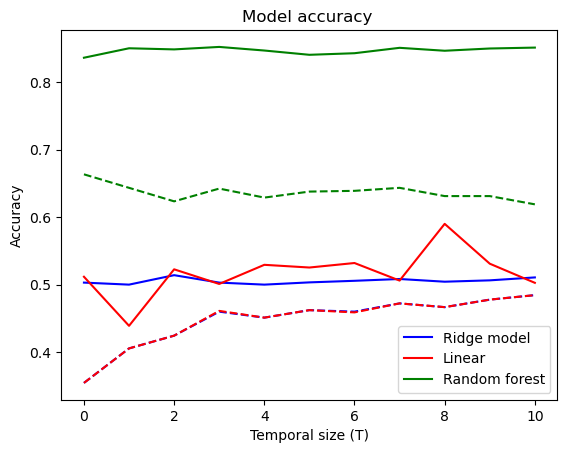

In [8]:
t_ridge_test=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_ridge_test_augmented.npy")
t_ridge_train=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_ridge_train_augmented.npy")
t_lin_test=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_lin_test_augmented.npy")
t_lin_train=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_lin_train_augmented.npy")
t_for_test=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_for_test_augmented.npy")
t_for_train=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_for_train_augmented.npy")
plt.plot(t_ridge_train,c="b",label="Ridge model")
plt.plot(t_ridge_test,"--",c="b")
plt.plot(t_lin_train,c="r",label="Linear")
plt.plot(t_lin_test,"--",c="r")
plt.plot(t_for_test,"--",c="g")
plt.plot(t_for_train,c="g",label="Random forest")
plt.legend(loc="lower right")
plt.xlabel("Temporal size (T)")
plt.ylabel("Accuracy")
plt.title("Model accuracy ")
plt.show()

In [17]:
n=int(len(data.X)/4)
reformed_X=data.X[0:n+2000,:].reshape(len(data.X[0:n+2000,:]),4*110*120)
scaler = StandardScaler()
reformed_X = scaler.fit_transform(reformed_X)
n_components = 5
pca = PCA(n_components=n_components)
reformed_X = pca.fit_transform(reformed_X)
n=int(len(data.X)/4)
train_X=reformed_X[:n]
train_y=data.y[:n]
test_X=reformed_X[n:n+2000]
test_y=data.y[n:n+2000]
print(test_X.shape,train_X.shape)
alpha = 1.0  # Regularization parameter
# Analyze the explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each component: {explained_variance}')
print(f'Total explained variance: {np.sum(explained_variance)}')

ValueError: cannot reshape array of size 726000000 into shape (2750,52800)

In [5]:
model_acc=np.zeros((4,len(range(100,3000,250)),))
for i,n_components in enumerate(range(100,3000,250)):
    print(i,n_components)
    #load in data
    data=loaded(t=4)
    data.applySobel()
    reformed_X=data.X.reshape(len(data.X),data.X.shape[1]*data.X.shape[2]*data.X.shape[3])
    #scale data
    scaler = StandardScaler()
    reformed_X = scaler.fit_transform(reformed_X)
    #pca 
    pca = PCA(n_components=n_components)
    reformed_X = pca.fit_transform(reformed_X)
    #split data
    train_X, test_X, train_y, test_y = train_test_split(reformed_X, data.y, test_size=0.2, random_state=42)
    #np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/testy_augmented",test_y)
    print(test_X.shape,train_X.shape)
    explained_variance = pca.explained_variance_ratio_
    #print(f'Explained variance by each component: {explained_variance}')
    print(f'Total explained variance: {np.sum(explained_variance)}')
    alpha = 1.0  # Regularization parameter

    #create best models
    print("RF")
    rf_model = RandomForestRegressor(n_estimators=25, random_state=42)
    rf_model.fit(train_X, train_y)
    predictionsA = np.round(rf_model.predict(test_X))
    a=(predictionsA.astype(np.uint8)-test_y)
    model_acc[0][i] = (len(a[a==0]))/len(predictionsA)

    predictionsA = np.round(rf_model.predict(train_X))
    a=(predictionsA.astype(np.uint8)-train_y)
    model_acc[1][i] = (len(a[a==0]))/len(predictionsA)
    #np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/predictionsA_augmented",predictionsA)
    del rf_model

    svm_model = SVC(decision_function_shape='ovo')
    # Train the SVM model
    svm_model.fit(train_X, train_y)

    # Make predictions on the test set
    predictionsB = svm_model.predict(test_X)
    a=(predictionsB.astype(np.uint8)-test_y)
    model_acc[2][i] = (len(a[a==0]))/len(predictionsB)

    predictionsB = svm_model.predict(train_X)
    a=(predictionsB.astype(np.uint8)-train_y)
    model_acc[3][i] = (len(a[a==0]))/len(predictionsB)

    del svm_model
    del data

#predictions
np.save(path+"/data/svm_vs_rfc_pca",model_acc)

0 100
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
(600, 100) (2400, 100)
Total explained variance: 0.8924914373858959
RF
1 350
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
(600, 350) (2400, 350)
Total explained variance: 0.912811980336632
RF
2 600
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
(600, 600) (2400, 600)
Total explained variance: 0.9262466166607772
RF
3 850
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
(600, 850) (2400, 850)
Total explained variance: 0.9378700121187662
RF
4 1100
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
(600, 1100) (2400, 1100)
Total explained variance: 0.9482308188237598
RF
5 1350
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
(600, 1350) (2400, 1350)
Total explained variance: 0.9575602332585316
RF
6 1600
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Mem

12 12


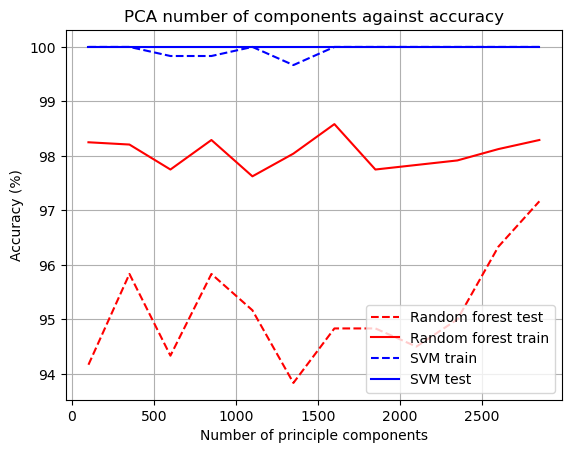

In [12]:
#np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/PCA size",model_acc)
model_acc=np.load(path+"/data/svm_vs_rfc_pca.npy")*100

print(len(range(100,3000,250)),len(model_acc[0]))
plt.plot(range(100,3000,250),model_acc[0],"--",c="r",label="Random forest test")
plt.plot(range(100,3000,250),model_acc[1],c="r",label="Random forest train")
plt.plot(range(100,3000,250),model_acc[2],"--",c="b",label="SVM train")
plt.plot(range(100,3000,250),model_acc[3],c="b",label="SVM test")
plt.legend(loc="lower right")
plt.grid(True)
plt.title("PCA number of components against accuracy")
plt.xlabel("Number of principle components")
plt.ylabel("Accuracy (%)")
plt.savefig(path+"/images/PCA_svm_frc.pdf")
plt.show()

In [ ]:
np.save("/its/home/drs25/GitHub/RoboSkin/Code/NewRigExperiments/data/testy_augmented",test_y)

In [24]:
a=(predictionsC-test_y).astype(np.int8)
correct=len(a[a==0])
print("Accuracy",correct/len(a))

Accuracy 0.6122222222222222


In [187]:
#predictionsA=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsA.npy").astype(np.uint8)
#predictionsB=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsB.npy").astype(np.uint8)
predictionsC=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsRandomForest.npy").astype(np.uint8)
test_y=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/test_y.npy")
"""a=(predictionsA-test_y).astype(np.int8)
correct=len(a[a==0])
print("Accuracy",correct/len(a))

a=(predictionsB-test_y).astype(np.int8)
correct=len(a[a==0])
print("Accuracy",correct/len(a))"""

a=(predictionsC-test_y).astype(np.int8)
correct=len(a[a==0])
print("Accuracy",correct/len(a))

Accuracy 0.745


In [ ]:
print(data.AugmentedX[0].shape)
110*120

(4, 110, 120)


13200

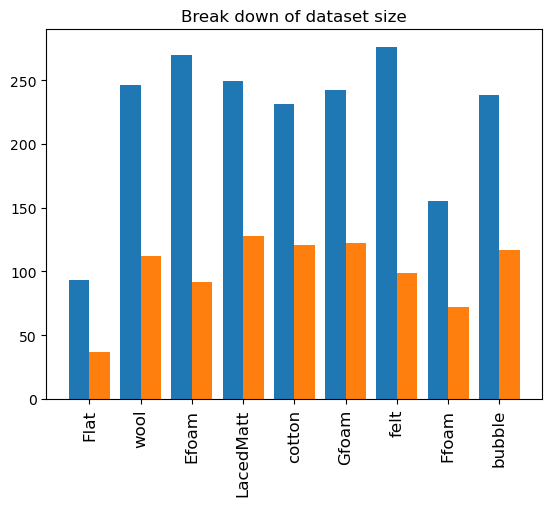

In [ ]:
#show distribution of data classes

num_classes = len(np.unique(train_y))
un=np.unique(test_y)
width = 0.4
indices = np.arange(num_classes)
num_in_classes=np.zeros((num_classes,))
num_in_test=np.zeros((num_classes,))
for i in range(num_classes):
    num_in_classes[i]=len(train_y[train_y==un[i]])
    num_in_test[i]=len(test_y[test_y==un[i]])
plt.bar(indices - width/2, num_in_classes, width, label='Correct')
plt.bar(indices + width/2, num_in_test, width, label='Incorrect')

plt.xticks([j for j in range(num_classes)],[data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=90,fontsize=12)
plt.title("Break down of dataset size")
plt.show()

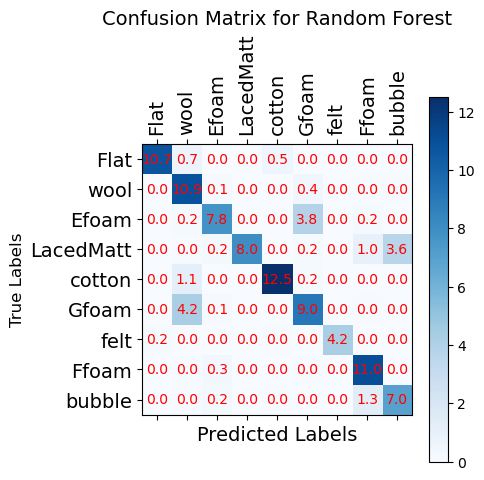

In [193]:
def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(test_y)
    for t, p in zip(true_labels, pred_labels):
        if p not in un: p=data.files.index(data.keys[find_nearest(un,p)])
        else: p=data.files.index(data.keys[int(p)])
        matrix[data.files.index(data.keys[t]), p] += 1
    matrix=matrix.astype(np.float64)
    matrix/=len(true_labels)
    return matrix
def find_nearest(array, value):
    # Calculate the absolute differences
    differences = np.abs(array - value)
    # Find the index of the minimum difference
    index_of_min = np.argmin(differences)
    # Return the value at that index in the original array
    return array[index_of_min]
# Combine all predictions
predictions = [predictionsC]
model_names = ['Random Forest', 'Linear Regression', 'Ridge Regression']
num_classes = len(np.unique(train_y))
un=np.unique(test_y)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(5*len(predictions), 5))

for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(test_y, preds, num_classes=len(np.unique(test_y)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm*100, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{round(value*100,1)}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/confusionRandomFOrest.pdf")
plt.show()

##  cLASSIFICATION MODELS


### RFC

In [27]:
acc_test=[]
acc_train=[]
data=loaded(t=4,filename="X_data_15.npz") #load in the dataset
data.applySobel()
data.augment()
reformed_X=data.X.reshape(len(data.X),data.X.shape[1]*data.X.shape[2]*data.X.shape[3]) #flatten the data for model
print("loaded data...")
for i in range(5):
    #
    train_X, test_X, train_y, test_y = train_test_split(reformed_X, data.y, test_size=0.2, random_state=np.random.randint(0,100))
    print(test_X.shape,train_X.shape)
    print("commence training...")
    model = RandomForestClassifier(max_depth=8, random_state=np.random.randint(0,100)) #start from random state for science reasons
    model.fit(train_X, train_y)
    #predictions on the test set
    y_pred = model.predict(test_X)
    #assert np.sum(y_pred)==np.sum(test_y), "Not all correct"
    y_pred2 = model.predict(train_X)

    #calculate test accuracy
    loss_test = y_pred != test_y
    correct_test = len(test_y) - np.sum(loss_test)
    acc_test.append(float(correct_test / len(test_y) *100))

    #calculate train accuracy
    loss_train = y_pred2 != train_y
    correct_train = len(train_y) - np.sum(loss_train)
    acc_train.append(float(correct_train / len(train_y) *100))


print("standard",acc_test,acc_train)

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
loaded data...
(1800, 52800) (7200, 52800)
commence training...
(1800, 52800) (7200, 52800)
commence training...
(1800, 52800) (7200, 52800)
commence training...
(1800, 52800) (7200, 52800)
commence training...
(1800, 52800) (7200, 52800)
commence training...
standard [99.94444444444444, 100.0, 100.0, 100.0, 100.0] [99.94444444444444, 100.0, 100.0, 100.0, 99.98611111111111]


In [29]:
print(np.average(acc_test),np.max(acc_test),np.max(acc_train))

99.9888888888889 100.0 100.0


### SVM

In [10]:

#load in numpy
data=np.load(datapath+"X_data_15.npz")
for array_name in data:
    X=(data[array_name].astype(np.uint8))
data=np.load(datapath+"y_data_15.npz")
for array_name in data:
    y=(data[array_name].astype(np.uint8))

encoder = OneHotEncoder(sparse_output=False)  # sparse_output=False returns a dense array
# Fit and transform the label data
onehot_labels = encoder.fit_transform(y.reshape(-1, 1))
print(onehot_labels[0])

X=X[:,:4].reshape((len(X),4*X.shape[2]*X.shape[3]))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [30]:
acc_test=[]
acc_train=[]
data=loaded(t=4,filename="X_data_15.npz")
data.applySobel()
for i in range(5):
    print("loaded data...")
    reformed_X=data.X.reshape(len(data.X),data.X.shape[1]*data.X.shape[2]*data.X.shape[3])
    train_X, test_X, train_y, test_y = train_test_split(reformed_X, data.y, test_size=0.6, random_state=np.random.randint(0,100))
    print(test_X.shape,train_X.shape)
    # Standardize the features (important for SVM)
    print("commence training...")
    # Create an SVM classifier
    svm_model = SVC(decision_function_shape='ovo')
    # Train the SVM model
    svm_model.fit(train_X, train_y)
    # Make predictions on the test set
    y_pred = svm_model.predict(test_X)
    y_pred2 = svm_model.predict(train_X)

    loss=np.abs(y_pred-test_y)
    loss[loss>0]=1
    correct=len(loss)-np.sum(loss)
    acc_test.append(correct/len(loss))
    loss=np.abs(y_pred2-train_y)
    loss[loss>0]=1
    correct=len(loss)-np.sum(loss)
    acc_train.append(correct/len(loss))

print("standard",acc_test,acc_train)

In [ ]:
acc_test=[]
acc_train=[]
for i in range(5):
    data=loaded(t=4,filename="X_data_newMorph.npz")
    data.applySobel()
    #data.augment()
    #d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
    #d.applySobel()

    #p20=d.X[np.where(d.y==3)]
    #data.X=np.concatenate([data.X,p20])
    #data.y=np.concatenate([data.y,np.zeros((len(p20)))+11])
    print("loaded data...")
    reformed_X=data.X.reshape(len(data.X),data.X.shape[1]*data.X.shape[2]*data.X.shape[3])
    train_X, test_X, train_y, test_y = train_test_split(reformed_X, data.y, test_size=0.2, random_state=np.random.randint(0,100))
    print(test_X.shape,train_X.shape)
    # Standardize the features (important for SVM)
    """scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)"""
    print("commence training...")
    # Create an SVM classifier
    svm_model = SVC(decision_function_shape='ovo')

    # Train the SVM model
    svm_model.fit(train_X, train_y)

    # Make predictions on the test set
    y_pred = svm_model.predict(test_X)
    y_pred2 = svm_model.predict(train_X)

    np.save(path+"/data/test_y_svm_concatp20",test_y)
    np.save(path+"/data/predictionsSVM_concatp20",y_pred)
    loss=np.abs(y_pred-test_y)
    loss[loss>0]=1
    correct=len(loss)-np.sum(loss)
    acc_test.append(correct/len(loss))
    loss=np.abs(y_pred2-train_y)
    loss[loss>0]=1
    correct=len(loss)-np.sum(loss)
    acc_train.append(correct/len(loss))

print("newmorph:",acc_test,acc_train)

In [ ]:
loss=np.abs(y_pred-test_y)
loss[loss>0]=1
correct=len(loss)-np.sum(loss)
print("Test Accuracy:",correct/len(loss))

loss=np.abs(y_pred2-train_y)
loss[loss>0]=1
correct=len(loss)-np.sum(loss)
print("Train Accuracy:",correct/len(loss))

In [ ]:
#   mew morph
#model 1
#
#model2
#
#model 3 
#
#model 4
#
#model 5
#
print(np.average([87.9,87.8,89.2,92.1,91.7]))
#   standard
#model 1
#
#model2
#
#model 3 
#
#model 4
#
#model 5
#
print(np.average([92.8, 99.9, 99.9,99.9, 99.9]))

In [15]:
d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
d.applySobel()

p20=d.X[np.where(d.y==3)]
p30=d.X[np.where(d.y==0)]
p40=d.X[np.where(d.y==2)]
p50=d.X[np.where(d.y==1)]
data=[p20,p30,p40,p50]
accs=[]
for i in range(4):
    x=data[i]
    label=11
    #x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
    x=x.reshape((len(x),x.shape[1]*x.shape[2]*x.shape[3]))
    pred=svm_model.predict(x)
    loss=np.abs(pred-11)
    loss[loss>0]=1
    correct=len(loss)-np.sum(loss)
    print(correct/len(loss) *100,"%")

Dataset size: 800 
Window size: 20 
Image: (110, 120)
Memory needed: 0.2 GB
100.0 %
100.0 %
100.0 %
100.0 %


In [9]:
# t exp
t_for_train=[]
t_for_test=[]
for i in range(1,12,1):
    print(i)
    d=data.X[:,:i]
    reformed_X=d.reshape(len(data.X),(i)*data.X.shape[2]*data.X.shape[2]) #
    train_X=reformed_X[:3000]
    train_y=data.y[0:3000]
    test_X=reformed_X[3000:3900]
    test_y=data.y[3000:3900]
    svm_model = SVC(decision_function_shape='ovo')
    # Fit the model
    svm_model.fit(train_X, train_y)
    predictionsX = svm_model.predict(train_X)
    predictions = svm_model.predict(test_X)
    loss=np.abs(predictionsX-train_y)
    loss[loss>0]=1
    correct=len(loss)-np.sum(loss)
    t_for_train.append(correct/len(loss))
    loss=np.abs(predictions-test_y)
    loss[loss>0]=1
    correct=len(loss)-np.sum(loss)
    t_for_test.append(correct/len(loss))
    del d
    del train_X
    del test_X
    del svm_model
t_for_test=np.array(t_for_test)
t_for_train=np.array(t_for_train)
np.save(path+"/data/t_svm_train",t_for_train)
np.save(path+"/data/t_svm_test",t_for_test)

1
2
3
4
5
6
7
8
9
10
11


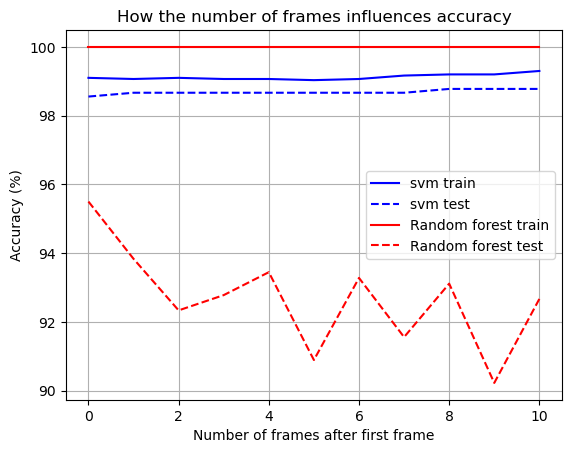

In [9]:
svm_train=np.load(path+"/data/t_svm_train.npy")
svm_test=np.load(path+"/data/t_svm_test.npy")
rfr_train=np.load(path+"/data/t_for_train.npy")//3
rfr_test=np.load(path+"/data/t_for_test.npy")
plt.plot(svm_train*100,c="b",label="svm train")
plt.plot(svm_test*100,"--",c="b",label="svm test")
plt.plot(rfr_train*100,c="r",label="Random forest train")
plt.plot(rfr_test*100,"--",c="r",label="Random forest test")

plt.title("How the number of frames influences accuracy")
plt.grid(True)
plt.xlabel("Number of frames after first frame")
plt.ylabel("Accuracy (%)")
plt.legend(loc="center right")
plt.savefig(path+"/images/SVMvsRFR_augmented.pdf")
plt.show()

In [7]:
t_for_test, t_for_train

(array([0.955     , 0.93833333, 0.92333333, 0.92777778, 0.93444444,
        0.90888889, 0.93277778, 0.91555556, 0.93111111, 0.90222222,
        0.92666667]),
 array([3.95388889, 3.93666667, 3.91444444, 3.93111111, 3.94277778,
        3.92666667, 3.92888889, 3.93555556, 3.92888889, 3.90222222,
        3.93388889]))

In [5]:
rfr_train

array([3.95388889, 3.93666667, 3.91444444, 3.93111111, 3.94277778,
       3.92666667, 3.92888889, 3.93555556, 3.92888889, 3.90222222,
       3.93388889])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


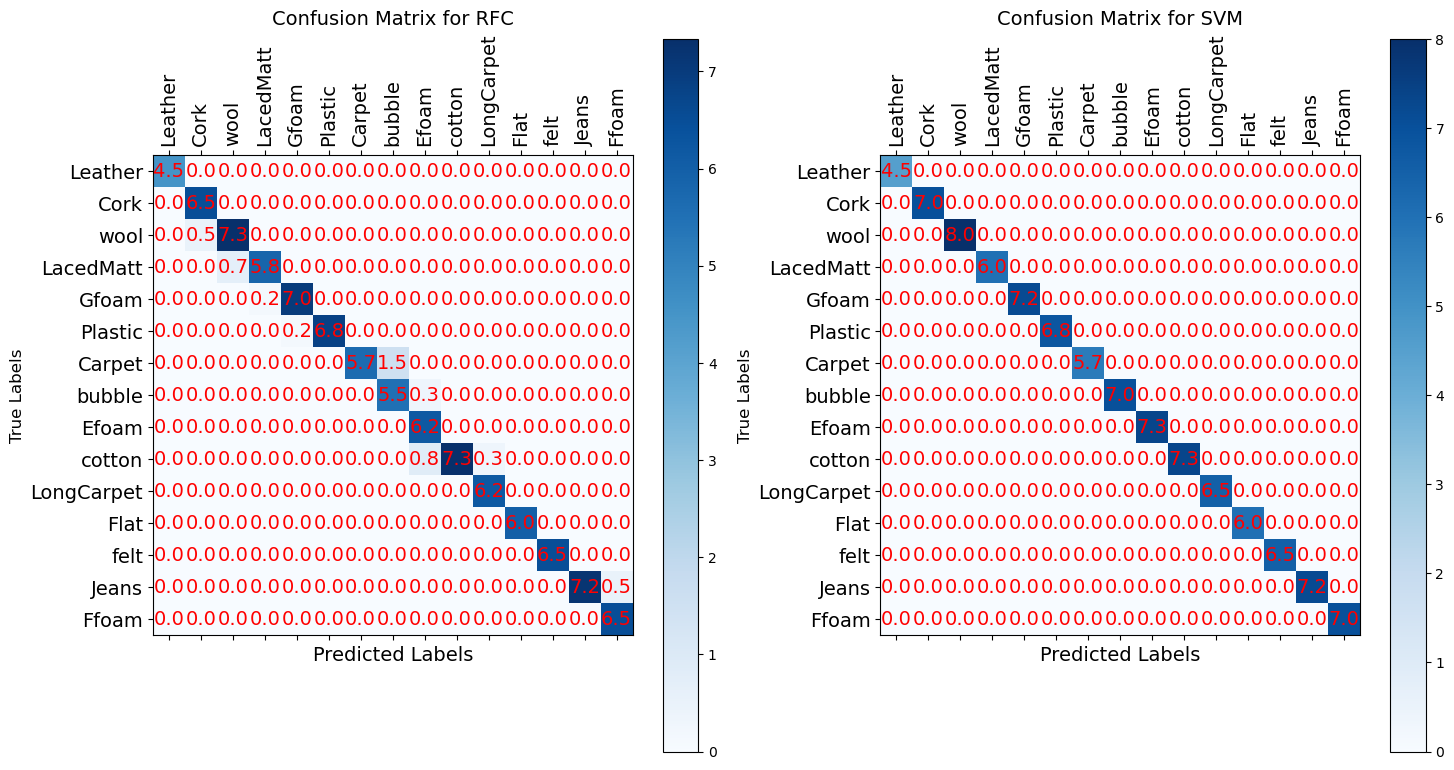

In [16]:
def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(test_y)
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    matrix=matrix.astype(np.float64)
    matrix/=len(true_labels)
    return matrix


SVM_lab=np.load(path+"/data/test_y_svm_t=20.npy")
SVM_pred=np.load(path+"/data/predictionsSVM_t=20.npy")
RF_lab=np.load(path+"/data/test_y_t=20.npy")
RF_pred=np.load(path+"/data/predictionsRandomForest_t=20.npy")

predictions = [np.round(RF_pred).astype(np.uint8),SVM_pred]
labels=[RF_lab,SVM_lab]
model_names = ["RFC",'SVM']
num_classes = len(np.unique(SVM_lab))
print(np.unique(labels[0]))
print(np.unique(predictions[0]))
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(15,8))


for i, preds in enumerate(predictions):
    num_classes = len(np.unique(labels[i]))
    un=np.unique(labels[i])
    cm = compute_confusion_matrix(predictions[i], labels[i], num_classes=num_classes)
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm*100, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{round(value*100,1)}', ha='center', va='center', color='red',fontsize=14)
    
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([data.keys[j] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([data.keys[j] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.savefig(path+"/images/SVM_t=20.pdf")
plt.show()

## MOdelling with points

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
(750, 4, 110, 120)
(750, 4, 110, 120) (750, 4, 260, 270)


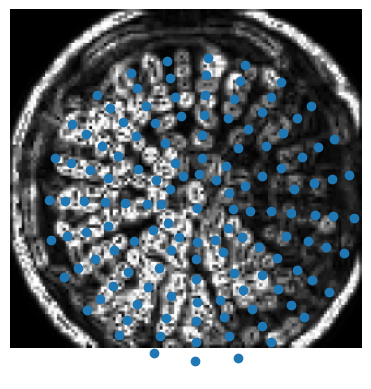

In [47]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p
sample=data.X[0:750]
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+140
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()

In [48]:
coords=coords.astype(np.uint8)
train_X, test_X, train_y, test_y = train_test_split(coords.reshape(len(coords),coords.shape[1]*coords.shape[2]*coords.shape[3]), data.y[0:750], test_size=0.2, random_state=42)
print(test_X.shape,train_X.shape)
# Standardize the features (important for SVM)
"""scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)"""

# Create an SVM classifier
svm_model = SVC(decision_function_shape='ovo')

# Train the SVM model
svm_model.fit(train_X, train_y)

# Make predictions on the test set
y_pred = svm_model.predict(test_X)
y_pred2 = svm_model.predict(train_X)

np.save(path+"/data/test_y_svm_points_gel",test_y)
np.save(path+"/data/predictionsSVM_points_gel",y_pred)
loss=np.abs(y_pred-test_y)
a=len(loss[loss==0])/len(loss)
print("Test Accuracy:",a)

loss=np.abs(y_pred2-train_y)
a=len(loss[loss==0])/len(loss)
print("Train Accuracy:",a)

(150, 1064) (600, 1064)
Test Accuracy: 0.18666666666666668
Train Accuracy: 0.21


In [38]:
# Define the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=25, random_state=42)

# Fit the model
rf_model.fit(train_X, train_y)

predictions = rf_model.predict(test_X)
diff=np.round(predictions)-test_y
a=len(diff[diff==0])/len(predictions)
print("Accuracy:",a*100,"%")
predictions = rf_model.predict(train_X)
diff=np.round(predictions)-train_y
a=len(diff[diff==0])/len(predictions)
print("Accuracy train:",a*100,"%")



Accuracy: 42.0 %
Accuracy train: 67.0 %


In [16]:
#generate fake dataset without points
def gen_image(image,pred):
    fake_im=np.zeros_like(image)
    for point in zip(pred[:,0].astype(np.uint16),pred[:,1].astype(np.uint16)):
        fake_im=cv2.circle(fake_im,point,3,(255),2)
    return fake_im


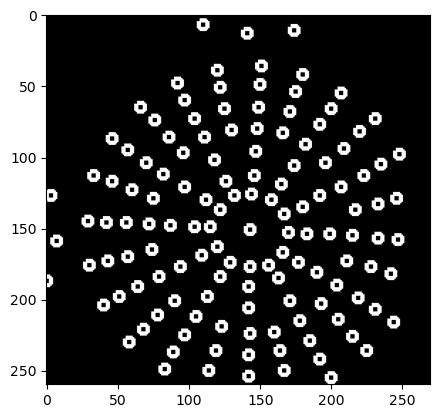

In [50]:

fake_data=np.zeros_like(X_alt)
for i in range(len(fake_data)):
    for j in range(len(fake_data[0])):
        fake_data[i][j]=gen_image(fake_data[i][j],predict(reg,X_alt[i][j])[0])

np.savez_compressed(datapath+"X_fake15_gel",fake_data)
np.savez_compressed(datapath+"y_fake15_gel",data.y[0:750])

plt.imshow(fake_data[0][0],cmap="gray")
plt.show()

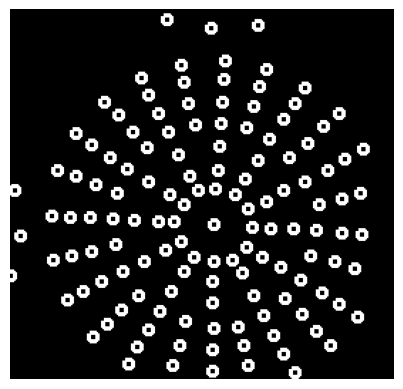

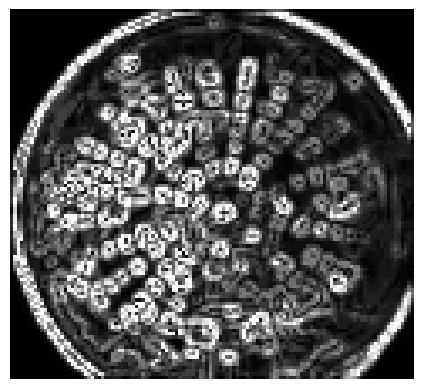

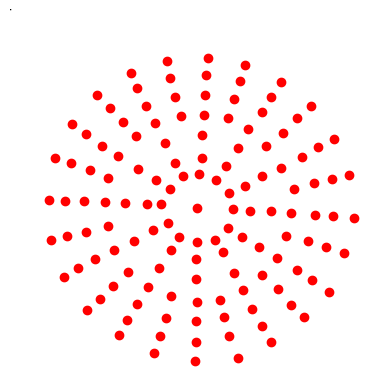

In [49]:
plt.imshow(gen_image(X_alt[i][j],predict(reg,X_alt[0][0])[0]),cmap="gray")
plt.axis("off")
plt.show()
plt.imshow(data.X[i][j],cmap="gray")
plt.axis("off")
plt.show()
im=np.zeros_like(X_alt[i][j])+255
im[0][0]=0
plt.imshow(im,cmap="gray")
plt.scatter(pred[:,0],pred[:,1],c="r")
plt.axis("off")
plt.show()

In [108]:
unique=[]
classes=np.unique(data.y[0:750])
for class_ in classes: #gather all the items of data
    unique.append(coords[np.where(data.y[0:750]==class_)])

averages=[]
stds=[]
for class_ in unique: #gather average movement for that class
    averages.append(np.average(class_,axis=0))
    stds.append(np.std(class_,axis=0))

In [138]:
def euclidean_distance(point1, point2):
    # Convert points to numpy arrays
    point1 = np.array(point1)
    point2 = np.array(point2)
    
    # Calculate the distance
    distance = np.linalg.norm(point1 - point2,axis=1)
    
    return distance

print(np.average(stds))

0.4861193821797396


(10, 133, 2) (10, 133, 2) 9


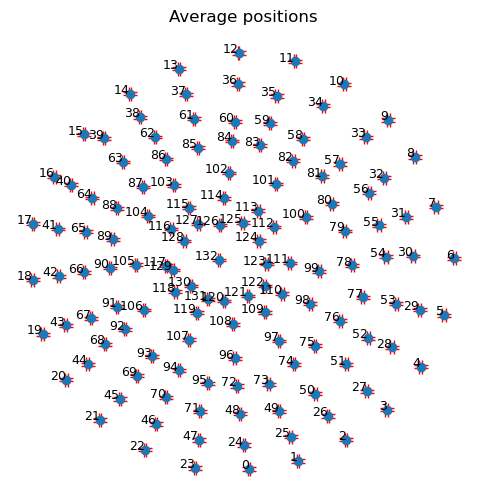

In [118]:
print(stds[0].shape,averages[0].shape,len(stds))
x_values, y_values = zip(*averages[8][0][:,])
std_x, std_y = zip(*stds[8][0])

# Plot the data
plt.figure(figsize=(10, 6))
plt.errorbar(x_values, y_values, xerr=std_x, yerr=std_y, fmt='o', ecolor='r', capsize=5, label='Data with Std Dev')
#plt.scatter(x_values, y_values)
# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Average positions')
#plt.legend()
# Add numbered labels to each point
for i, (x, y) in enumerate(zip(x_values, y_values)):
    plt.text(x, y, str(i), fontsize=9, ha='right')
plt.gca().set_aspect('equal', adjustable='box')
# Show plot
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/regressionPointsErrorBar.pdf")
plt.show()

1.7494005639627375
1.3896483514179758
0.9899359308615178
1.7792525356456395
1.310232617047245
1.3676283388134836
1.3934489451281236
1.615968446958976
1.5891262508110084


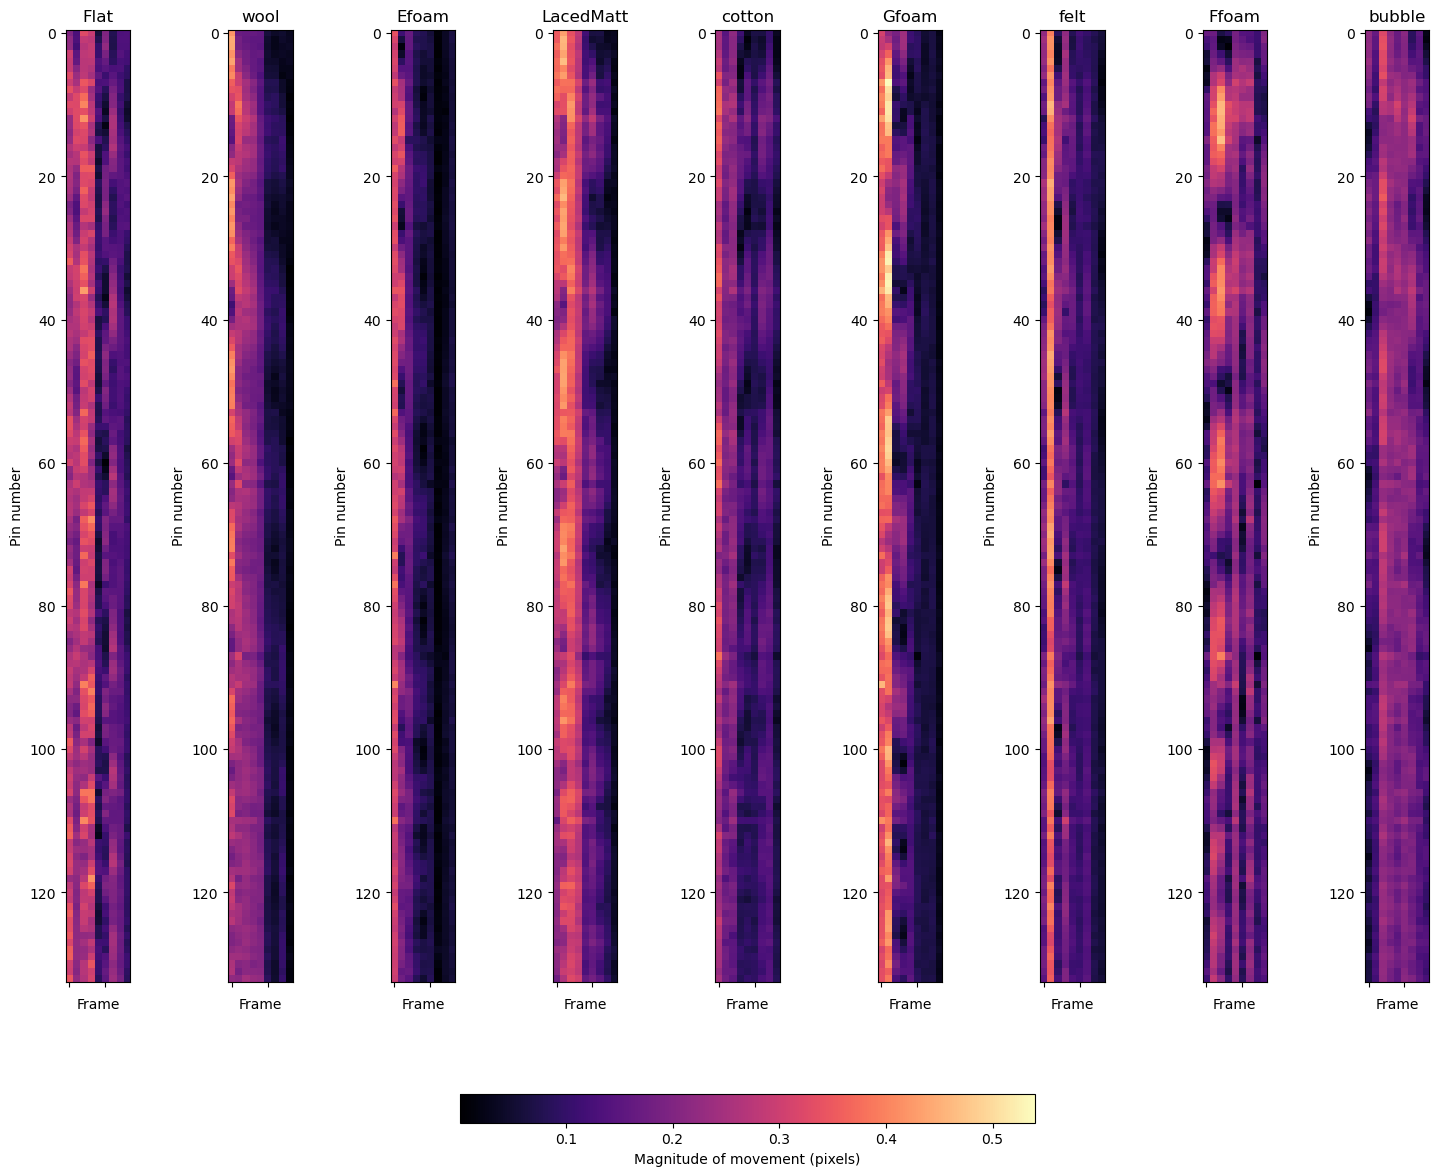

In [156]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def plotchange(average):
    magnitudes=[]
    for t in range(len(average)-1):
        magnitudes.append(euclidean_distance(average[t],average[t+1]))
    ar=np.array(magnitudes).T
    return ar#(ar-np.min(ar))/(np.max(ar)-np.min(ar))

fig, axes = plt.subplots(1, len(averages), figsize=(15,12))
axes = axes.flatten()

all_magnitudes = np.concatenate([plotchange(avg) for avg in averages])
vmin = np.min(all_magnitudes)
vmax = np.max(all_magnitudes)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = cm.magma
# Plot each set of averages
for i in range(len(averages)):
    m = plotchange(averages[i])
    print(np.average(np.sum(m,axis=1)))
    im = axes[i].imshow(m, norm=norm, cmap=cmap)
    axes[i].set_ylabel("Pin number")
    axes[i].set_xlabel("Frame")
    axes[i].set_xticklabels([])
    axes[i].set_title(data.keys[classes[i]])

# Add color bar at the bottom
plt.tight_layout()
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.1,fraction=0.05, shrink=0.4)
cbar.set_label('Magnitude of movement (pixels)')

plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/pinMovementsTexture.pdf")
plt.show()

(9, 133, 11)


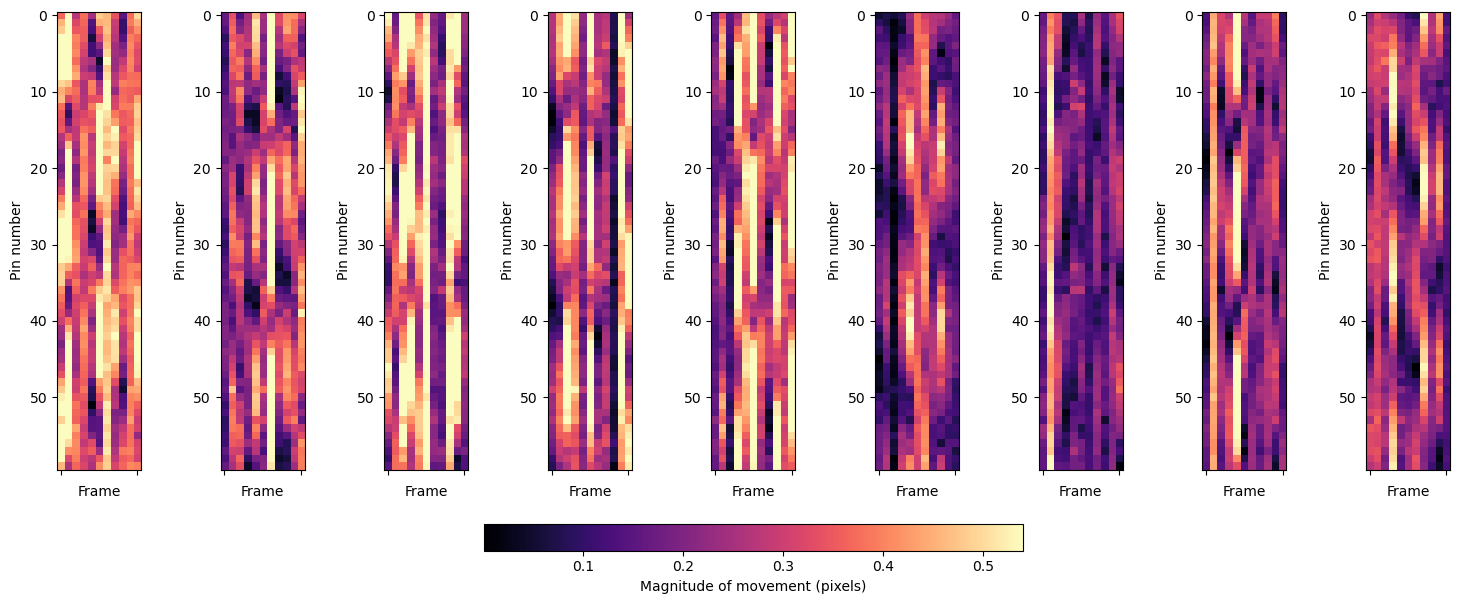

In [175]:
fig, axes = plt.subplots(1, len(averages), figsize=(15,6))
axes = axes.flatten()

all_magnitudes = np.array([plotchange(avg) for avg in unique[3][0:11]]).T
all_magnitudes = (all_magnitudes - np.min(all_magnitudes ))/(np.max(all_magnitudes )-np.min(all_magnitudes ))
#vmin = np.min(all_magnitudes)
#vmax = np.max(all_magnitudes)
#norm = Normalize(vmin=vmin, vmax=vmax)
#cmap = cm.magma
# Plot each set of averages
print(all_magnitudes.shape)
for i in range(len(averages)):
    im = axes[i].imshow(all_magnitudes[i][0:60], norm=norm, cmap=cmap)
    axes[i].set_ylabel("Pin number")
    axes[i].set_xlabel("Frame")
    axes[i].set_xticklabels([])

# Add color bar at the bottom
plt.tight_layout()
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.1,fraction=0.05, shrink=0.4)
cbar.set_label('Magnitude of movement (pixels)')

plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/pinMovementsTextureSame.pdf")
plt.show()

## MOdelling with magnitudes

In [3]:
distances=np.load(path+"/data/distances.npy")
y=np.load(path+"/data/distancesy.npy")
train_X, test_X, train_y, test_y = train_test_split(distances.reshape((len(distances),-1)), y, test_size=0.2, random_state=42)
print(test_X.shape,train_X.shape)
# Standardize the features (important for SVM)
"""scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)"""

# Create an SVM classifier
svm_model = SVC(decision_function_shape='ovo')

# Train the SVM model
svm_model.fit(train_X, train_y)

# Make predictions on the test set
y_pred = svm_model.predict(test_X)
y_pred2 = svm_model.predict(train_X)

np.save(path+"/data/test_y_svm_points_gel",test_y)
np.save(path+"/data/predictionsSVM_points_gel",y_pred)
loss=np.abs(y_pred-test_y)
a=len(loss[loss==0])/len(loss)
print("Test Accuracy:",a)

loss=np.abs(y_pred2-train_y)
a=len(loss[loss==0])/len(loss)
print("Train Accuracy:",a)


In [5]:
distances=np.load(path+"/data/distances.npy")
y=np.load(path+"/data/distancesy.npy")
train_X, test_X, train_y, test_y = train_test_split(distances.reshape((len(distances),-1)), y, test_size=0.2, random_state=42)
print(test_X.shape,train_X.shape)
# Standardize the features (important for SVM)
"""scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)"""

# Create an SVM classifier
svm_model = SVC(decision_function_shape='ovo')

# Train the SVM model
svm_model.fit(train_X, train_y)

# Make predictions on the test set
y_pred = svm_model.predict(test_X)
y_pred2 = svm_model.predict(train_X)

np.save(path+"/data/test_y_svm_vel_gel",test_y)
np.save(path+"/data/predictionsSVM_vel_gel",y_pred)
loss=np.abs(y_pred-test_y)
a=len(loss[loss==0])/len(loss)
print("Test Accuracy:",a)

loss=np.abs(y_pred2-train_y)
a=len(loss[loss==0])/len(loss)
print("Train Accuracy:",a)

(600, 532) (2400, 532)
Test Accuracy: 0.495
Train Accuracy: 0.58125


In [6]:
distances=np.load(path+"/data/distances.npy")
y=np.load(path+"/data/distancesy.npy")
train_X, test_X, train_y, test_y = train_test_split(distances.reshape((len(distances),-1)), y, test_size=0.2, random_state=42)
print(test_X.shape,train_X.shape)

# Define the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=25, random_state=42)

# Fit the model
rf_model.fit(train_X, train_y)

predictions = rf_model.predict(test_X)
diff=np.round(predictions)-test_y
a=len(diff[diff==0])/len(predictions)
print("Accuracy:",a*100,"%")
predictions = rf_model.predict(train_X)
diff=np.round(predictions)-train_y
a=len(diff[diff==0])/len(predictions)
print("Accuracy train:",a*100,"%")


(600, 532) (2400, 532)
Accuracy: 15.166666666666668 %
Accuracy train: 32.666666666666664 %
